# Description of the breast lesion deep learning project

## Motivation and notes

## Publications data sources

Al-Dhabyani, W., Gomaa, M., Khaled, H., & Fahmy, A. (2019). Dataset of breast ultrasound images. Data in brief, 28, 104863. https://doi.org/10.1016/j.dib.2019.104863

Pawłowska, A., Ćwierz-Pieńkowska, A., Domalik, A., Jaguś, D., Kasprzak, P., Matkowski, R., Fura, Ł., Nowicki, A., & Zolek, N. (2024). A Curated Benchmark Dataset for Ultrasound Based Breast Lesion Analysis (Breast-Lesions-USG) (Version 1) [dataset]. The Cancer Imaging Archive. https://doi.org/10.7937/9WKK-Q141

**the following data is not included yet**

A. Abbasian Ardakani, A. Mohammadi, M. Mirza-Aghazadeh-Attari, U.R. Acharya, An open-access breast lesion ultrasound image database‏: Applicable in artificial intelligence studies, Computers in Biology and Medicine, 152 (2023) 106438. https://doi.org/10.1016/j.compbiomed.2022.106438



In [99]:
# Imports
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import os
from PIL import Image
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

# Data exploration 

## Plotting example images

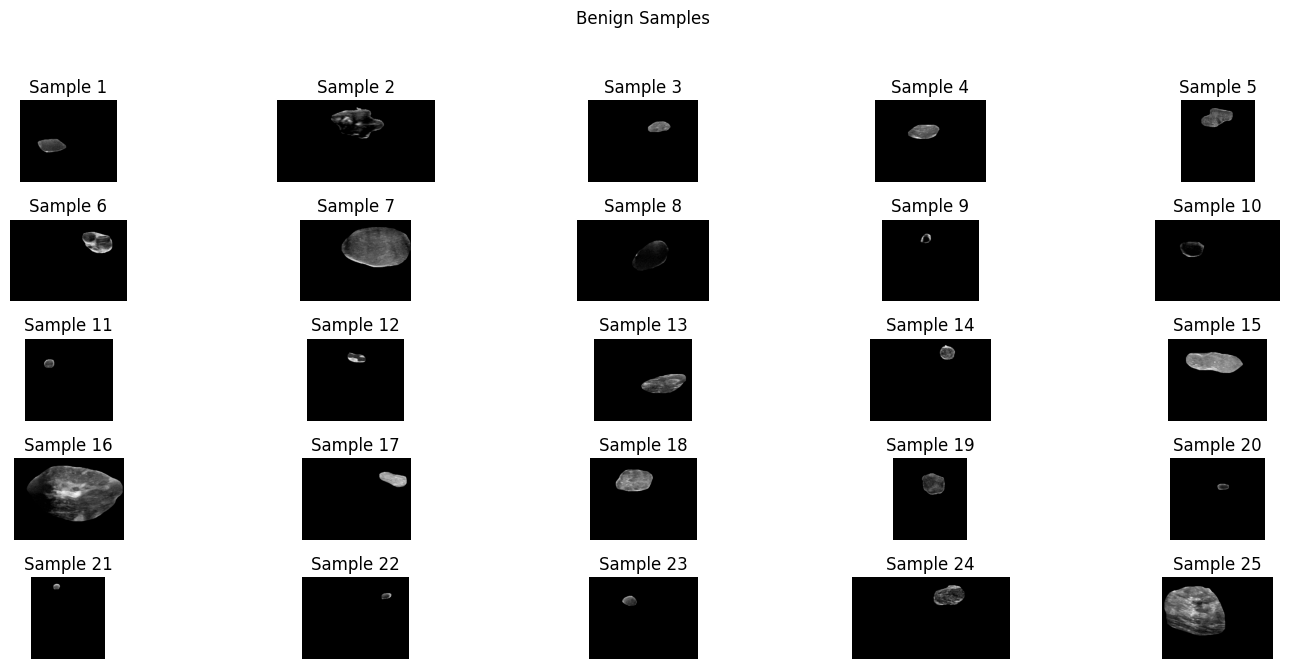

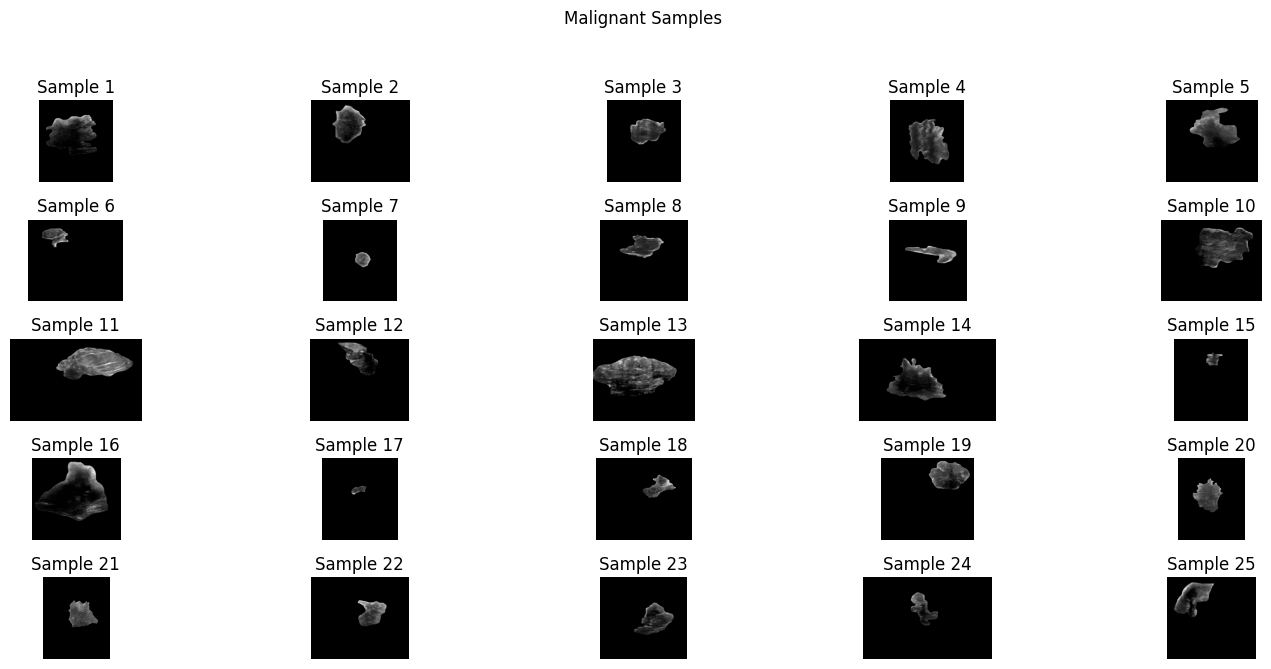

In [100]:
def plot_class_samples(base_path, class_name, num_samples=10):
    plt.figure(figsize=(15, 7))
    class_folder = os.path.join(base_path, class_name)
    image_files = [os.path.join(class_folder, f) for f in os.listdir(class_folder) if f.endswith('.png')]

    for i in range(min(num_samples, len(image_files))):
        img_path = image_files[i]
        img = Image.open(img_path).convert('L')  # Load in grayscale
        ax = plt.subplot(5, 5, i + 1)  # Adjust subplot grid for 10 images: 2 rows and 5 columns
        ax.imshow(img, cmap='gray')
        ax.set_title(f"Sample {i + 1}")
        ax.axis('off')

    plt.suptitle(f"{class_name.capitalize()} Samples")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

training_path = '/kaggle/input/breast-lesion-dataset-wo-marks3/Breast_lesion_dataset3/Training_data'
plot_class_samples(training_path, 'benign', num_samples=25)

plot_class_samples(training_path, 'malignant', num_samples=25)

In [101]:
def create_classification_df(base_path):
    categories = ['benign', 'malignant']
    data = []

    for category in categories:
        class_folder = os.path.join(base_path, category)
        # List files in the directory
        image_files = [f for f in os.listdir(class_folder) if f.endswith('.png')]

        # Create a list of dictionaries containing the filename and classification
        data.extend([{'filename': f, 'classification': category} for f in image_files])

    df = pd.DataFrame(data)
    return df

training_path = '/kaggle/input/breast-lesion-dataset-wo-marks3/Breast_lesion_dataset3/Training_data'
test_path = '/kaggle/input/breast-lesion-dataset-wo-marks3/Breast_lesion_dataset3/Test_data'
train_df = create_classification_df(training_path)
test_df = create_classification_df(test_path)

df = pd.concat([train_df, test_df])
print(train_df.shape)
print(test_df.shape)
print(df.head())

(668, 2)
(100, 2)
           filename classification
0    benign (2).png         benign
1       case037.png         benign
2  benign (390).png         benign
3  benign (357).png         benign
4       case231.png         benign


## Is there a class imbalance? 

In [102]:
print(train_df['classification'].value_counts())
print(test_df['classification'].value_counts())

classification
benign       442
malignant    226
Name: count, dtype: int64
classification
benign       50
malignant    50
Name: count, dtype: int64


# Model building

## Loading data with keras.preprocessing function (tip from Vlad)

In [103]:
training_path = '/kaggle/input/breast-lesion-dataset-wo-marks3/Breast_lesion_dataset3/Training_data'
test_path = '/kaggle/input/breast-lesion-dataset-wo-marks3/Breast_lesion_dataset3/Test_data'


# parameters
batch_size = 32
img_height = 224
img_width = 224

# Create training dataset from directory
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    training_path,
    labels='inferred',
    label_mode='binary',   # Labels are returned as integers
    class_names=['benign', 'malignant'], # class names
    color_mode='grayscale',
    batch_size=batch_size,
    image_size=(img_height, img_width),  # resize images to the specified size
    shuffle=True,        # shuffles the data
    seed=123,            # seed for shuffling and transformations
    validation_split=0.2,  # image proportion for validation
    subset='training',
)

# Crreating validation set
validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    training_path,
    labels='inferred',
    label_mode='binary',
    class_names=['benign', 'malignant'],
    color_mode='grayscale',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset='validation',
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory=test_path,
    shuffle=True,
    label_mode='binary',
    image_size=(224, 224),
    color_mode='grayscale',
    batch_size=32)

Found 668 files belonging to 2 classes.
Using 535 files for training.
Found 668 files belonging to 2 classes.
Using 133 files for validation.
Found 100 files belonging to 2 classes.


## Data preprocessing and augmentation 

## Edge detection: is it true that benign lesions are rather round and malignant ones are rather irregularly shaped? 

## Baseline model


In [104]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras import layers


model = Sequential()


model.add(layers.Conv2D(filters = 32, kernel_size = (3,3), activation="relu", padding = "same",input_shape=(img_height, img_width, 1)))
model.add(layers.MaxPooling2D(pool_size=(2, 2)) )


model.add(layers.Conv2D(filters = 64, kernel_size = (3,3), activation="relu", padding = "same"))
model.add(layers.MaxPooling2D(pool_size=(2, 2)) )


model.add(layers.Conv2D(filters = 64, kernel_size = (3,3), activation="relu", padding = "same"))
model.add(layers.MaxPooling2D(pool_size=(2, 2)) )

model.add(layers.Conv2D(filters = 128, kernel_size = (3,3), activation="relu", padding = "same"))
model.add(layers.MaxPooling2D(pool_size=(2, 2)) )

model.add(layers.Flatten())

# Here we flatten our data to end up with just one dimension

model.add(layers.Dense(64, activation="relu"))

model.add(layers.Dense(1, activation="sigmoid"))


# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(dataset,
                    validation_data=validation_dataset,
                    epochs=10)

# Evaluate the model
loss, accuracy = model.evaluate(validation_dataset)
print("Validation Loss:", loss)
print("Validation Accuracy:", accuracy)

Epoch 1/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 177ms/step - accuracy: 0.5348 - loss: 4.6294 - val_accuracy: 0.6316 - val_loss: 0.8250
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.6232 - loss: 3.5624 - val_accuracy: 0.6842 - val_loss: 3.9982
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.6772 - loss: 0.9649 - val_accuracy: 0.6541 - val_loss: 0.7236
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.6690 - loss: 0.8178 - val_accuracy: 0.6917 - val_loss: 0.7167
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.6633 - loss: 0.7001 - val_accuracy: 0.6917 - val_loss: 0.6722
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.6769 - loss: 0.6429 - val_accuracy: 0.6917 - val_loss: 0.6932
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.6693 - loss: 0.6242 - val_accuracy: 0.6917 - val_loss: 0.6880
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.7176 - loss: 0.6468 - val_accuracy: 0.6842 - 

In [105]:
def plot_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('accuracy')
    ax[1].plot(history.epoch, history.history["accuracy"], label="Train acc")
    ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation acc")
    ax[0].legend()
    ax[1].legend()

In [106]:
def plot_compare_history(history, name_history, history_1, name_history_1):

    fig, ax = plt.subplots(1, 2, figsize=(15,5))

    ax[0].set_title('loss')

    ax[0].plot(history.epoch, history.history["loss"], label="Train loss " + name_history)
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss " + name_history)

    ax[0].plot(history_1.epoch, history_1.history["loss"], label="Train loss " + name_history_1)
    ax[0].plot(history_1.epoch, history_1.history["val_loss"], label="Validation loss " + name_history_1)

    ax[1].set_title('Accuracy')

    ax[1].plot(history.epoch, history.history["accuracy"], label="Train Accuracy " + name_history)
    ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation Accuracy " + name_history)

    ax[1].plot(history_1.epoch, history_1.history["accuracy"], label="Train Accuracy " + name_history_1)
    ax[1].plot(history_1.epoch, history_1.history["val_accuracy"], label="Validation Accuracy " + name_history_1)

    ax[0].legend()
    ax[1].legend()


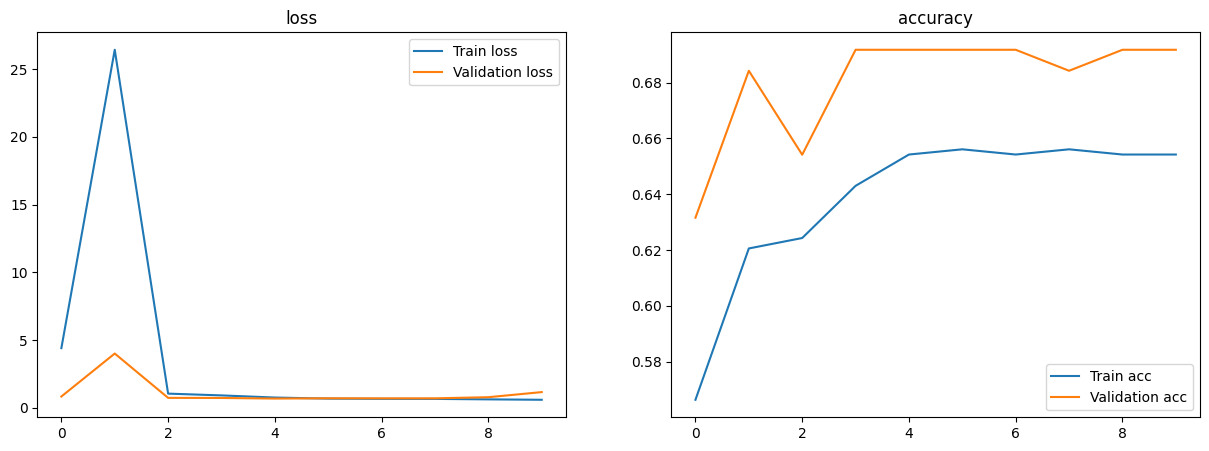

In [107]:
plot_history(history)

## Data Augmentation

### Building the model

In [108]:
model_2 = Sequential()


# Data Augmentation Layers

model_2.add(layers.RandomFlip("horizontal"))
model_2.add(layers.RandomZoom(0.1))
model_2.add(layers.RandomTranslation(0.2, 0.2))
model_2.add(layers.RandomRotation(0.1))



# Convolutional Layers

model_2.add(layers.Conv2D(filters = 32, kernel_size = (3,3), activation="relu", padding = "same", input_shape=(img_height, img_width, 1)))
model_2.add(layers.MaxPooling2D(pool_size=(2, 2)))


model_2.add(layers.Conv2D(filters = 64, kernel_size = (3,3), activation="relu", padding = "same"))
model_2.add(layers.MaxPooling2D(pool_size=(2, 2)))


model_2.add(layers.Conv2D(filters = 64, kernel_size = (3,3), activation="relu", padding = "same"))
model_2.add(layers.MaxPooling2D(pool_size=(2, 2)))

model_2.add(layers.Conv2D(filters = 128, kernel_size = (3,3), activation="relu", padding = "same"))
model_2.add(layers.MaxPooling2D(pool_size=(2, 2)))

model_2.add(layers.Flatten())

model_2.add(layers.Dense(64, activation="relu"))


model_2.add(layers.Dense(1, activation="sigmoid"))


# Compile the model
model_2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history2 = model_2.fit(dataset,
                    validation_data=validation_dataset,
                    epochs=10)

# Evaluate the model
loss, accuracy = model_2.evaluate(validation_dataset)
print("Validation Loss:", loss)
print("Validation Accuracy:", accuracy)

Epoch 1/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.5092 - loss: 1.8751 - val_accuracy: 0.6617 - val_loss: 0.6726
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.6451 - loss: 0.6757 - val_accuracy: 0.7068 - val_loss: 0.6427
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.6683 - loss: 0.6295 - val_accuracy: 0.7669 - val_loss: 0.6044
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.7102 - loss: 0.6001 - val_accuracy: 0.6992 - val_loss: 0.5752
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.6854 - loss: 0.5800 - val_accuracy: 0.7368 - val_loss: 0.5600
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.7029 - loss: 0.5382 - val_accuracy: 0.6992 - val_loss: 0.5786
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.7132 - loss: 0.5523 - val_accuracy: 0.6917 - val_loss: 0.5810
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.7245 - loss: 0.5641 - val_accuracy: 0.8271 - v

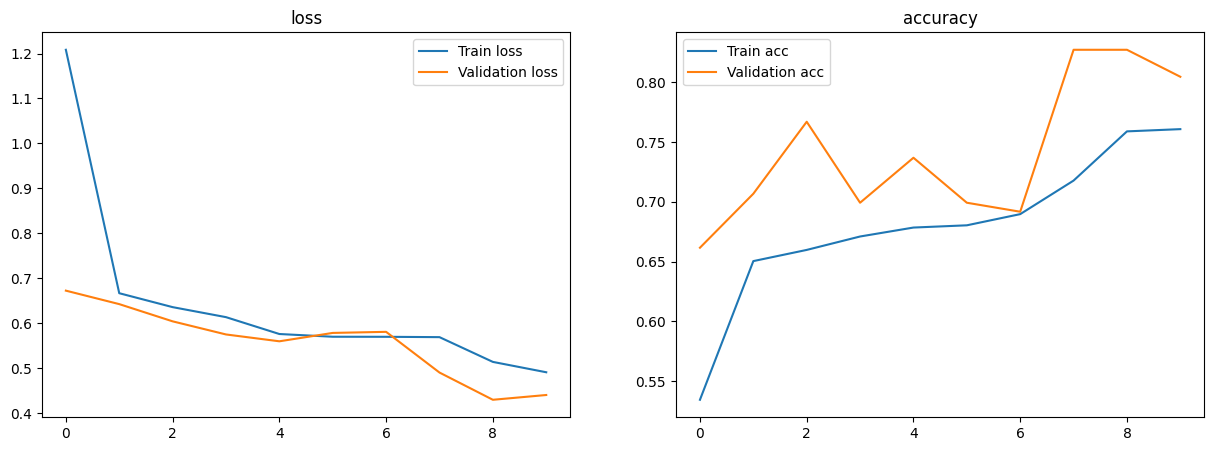

In [109]:
plot_history(history2)

In [110]:

from tensorflow.keras import callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping



model_3 = Sequential()


# Data Augmentation Layers

model_3.add(layers.RandomFlip("horizontal"))
model_3.add(layers.RandomZoom(0.1))
model_3.add(layers.RandomTranslation(0.2, 0.2))
model_3.add(layers.RandomRotation(0.1))



# Convolutional Layers

model_3.add(layers.Conv2D(filters = 32, kernel_size = (3,3), activation="relu", padding = "same", input_shape=(img_height, img_width, 1)))
model_3.add(layers.MaxPooling2D(pool_size=(2, 2)))


model_3.add(layers.Conv2D(filters = 64, kernel_size = (3,3), activation="relu", padding = "same"))
model_3.add(layers.MaxPooling2D(pool_size=(2, 2)))


model_3.add(layers.Conv2D(filters = 64, kernel_size = (3,3), activation="relu", padding = "same"))
model_3.add(layers.MaxPooling2D(pool_size=(2, 2)))

model_3.add(layers.Conv2D(filters = 128, kernel_size = (3,3), activation="relu", padding = "same"))
model_3.add(layers.MaxPooling2D(pool_size=(2, 2)))

model_3.add(layers.Flatten())

model_3.add(layers.Dense(64, activation="relu"))


model_3.add(layers.Dense(1, activation="sigmoid"))


# Compile the model
model_3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])



#This callback will save the model to a file after every epoch
model_checkpoint = callbacks.ModelCheckpoint("model_best.keras", monitor='val_loss', verbose=0, save_best_only=True)

#This callback reduces the learning rate when a metric has stopped improving.
lr_reducer = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0)

#This callback will stop the training if the monitored metric (in this case, validation loss) does not improve.
early_stopper = callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, restore_best_weights=True)




# Train the model
history3 = model_3.fit(dataset, validation_data=validation_dataset, epochs=1000,batch_size=32, callbacks=[model_checkpoint, lr_reducer, early_stopper])



# Evaluate the model
loss, accuracy = model_3.evaluate(validation_dataset)
print("Validation Loss:", loss)
print("Validation Accuracy:", accuracy)


Epoch 1/1000
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.5702 - loss: 2.3487 - val_accuracy: 0.6015 - val_loss: 0.6694 - learning_rate: 0.0010
Epoch 2/1000
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.6488 - loss: 0.6669 - val_accuracy: 0.7143 - val_loss: 0.6684 - learning_rate: 0.0010
Epoch 3/1000
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.7040 - loss: 0.6144 - val_accuracy: 0.6692 - val_loss: 0.6355 - learning_rate: 0.0010
Epoch 4/1000
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.6621 - loss: 0.6015 - val_accuracy: 0.7143 - val_loss: 0.5699 - learning_rate: 0.0010
Epoch 5/1000
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.6861 - loss: 0.5919 - val_accuracy: 0.6992 - val_loss: 0.5461 - learning_rate: 0.0010
Epoch 6/1000
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.6965 - loss: 0.5322 - val_accuracy: 0.7594 - val_loss: 0.5497 - learning_rate: 0.0010
Epoch 7/1000
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.6732 - loss: 0.

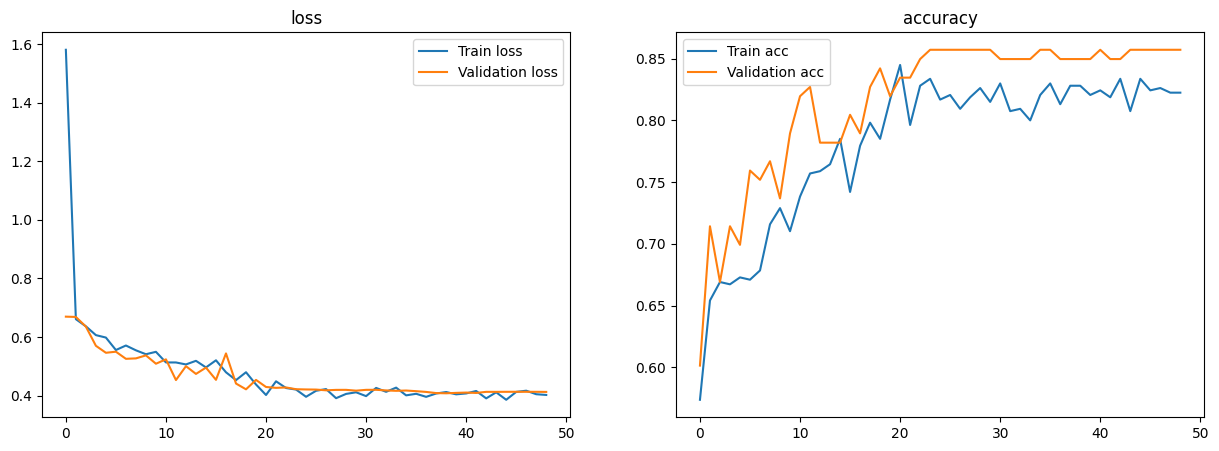

In [111]:
plot_history(history3)

In [112]:
# Evaluate the model on test_dataset
loss, accuracy = model_3.evaluate(test_dataset)
print("Validation Loss:", loss)
print("Validation Accuracy:", accuracy)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8063 - loss: 0.4421 
Validation Loss: 0.4289816915988922
Validation Accuracy: 0.8100000023841858


## EfficientNetB2

In [132]:

# parameters for the dataset generation
batch_size = 32
img_height = 224  # what should the input size be? #224
img_width = 224   # ?

# Create training dataset from directory
dataset_rgb = tf.keras.preprocessing.image_dataset_from_directory(
    training_path,
    labels='inferred',
    label_mode='int',   # Labels are returned as integers
    class_names=['benign', 'malignant'], # class names
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(img_height, img_width),  # resize images to the specified size
    shuffle=True,        # shuffles the data
    seed=123,            # seed for shuffling and transformations
    validation_split=0.2,  # image proportion for validation
    subset='training',
)

# Crreating validation set
validation_dataset_rgb  = tf.keras.preprocessing.image_dataset_from_directory(
    training_path,
    labels='inferred',
    label_mode='int',
    class_names=['benign', 'malignant'],
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset='validation',
)


# Load the test dataset
test_dataset_rgb  = tf.keras.preprocessing.image_dataset_from_directory(
    directory=test_path,
    shuffle=True,
    image_size=(224, 224),
    color_mode='rgb',
    batch_size=32)

Found 668 files belonging to 2 classes.
Using 535 files for training.
Found 668 files belonging to 2 classes.
Using 133 files for validation.
Found 100 files belonging to 2 classes.


In [122]:
from tensorflow.keras import layers, Model, callbacks
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.applications import EfficientNetV2B2
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense
from tensorflow.keras.losses import BinaryCrossentropy

# Parameters for the dataset and model
batch_size = 64
num_classes = 2  # binary classification (benign vs malignant)


input_tensor=Input(shape=(img_height, img_width, 3))

x=layers.RandomFlip("horizontal")(input_tensor)
x=layers.RandomZoom([0.1, 0.3] )(x)
x=layers.RandomTranslation(0.3, 0.3)(x)
x=layers.RandomRotation([-1,1])(x)



#x=layers.RandomFlip("horizontal")(input_tensor)
#x=layers.RandomZoom(0.1)(x)
#x=layers.RandomTranslation(0.2, 0.2)(x)
#x=layers.RandomRotation(0.1)(x)



# Load the pre-trained EfficientNetB0 model
base_model = EfficientNetV2B2(weights='imagenet', include_top=False, input_tensor=input_tensor)(x)

# Freeze the pre-trained layers
base_model.trainable = False


# Add custom classification head
x = GlobalAveragePooling2D()(base_model)
x = Dense(128, activation='relu')(x)
output = Dense(2, activation='softmax')(x)



# Create the model
model_eff = Model(inputs=input_tensor, outputs=output)

# Compile the model
model_eff.compile(optimizer=Adam(learning_rate=0.0001), loss=SparseCategoricalCrossentropy(), metrics=['accuracy'])

# Display the model summary
model_eff.summary()

# Assuming you have defined your training and validation datasets
# Replace `train_dataset` and `val_dataset` with your actual datasets



#This callback will save the model to a file after every epoch
model_checkpoint = callbacks.ModelCheckpoint("model_best.keras", monitor='val_loss', verbose=0, save_best_only=True)

#This callback reduces the learning rate when a metric has stopped improving.
lr_reducer = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0)

#This callback will stop the training if the monitored metric (in this case, validation loss) does not improve.
early_stopper = callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, restore_best_weights=True)





# Train the model

history_eff_improved= model_eff.fit(dataset_rgb,
                    validation_data=validation_dataset_rgb,
                    epochs=50,  batch_size=batch_size, callbacks=[model_checkpoint, lr_reducer, early_stopper]
                          )

# Evaluate the model
loss, accuracy = model_eff.evaluate(validation_dataset_rgb)
print("Validation Loss:", loss)
print("Validation Accuracy:", accuracy)


Model: "functional_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_7 (RandomFlip)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_7 (RandomZoom)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_translation_7            │ (None, 224, 224, 3)    │             0 │
│ (RandomTranslation)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_7               │ (None, 224, 224, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b2 (Functional)  │ (None, 7, 7, 1408)     │     8,769,374 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1408)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │       180,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,949,984 (34.14 MB)

 Trainable params: 8,867,696 (33.83 MB)

 Non-trainable params: 82,288 (321.44 KB)

Epoch 1/50


2024-05-15 14:42:45.908034: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_31_1/efficientnetv2-b2_1/block1b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


17/17 ━━━━━━━━━━━━━━━━━━━━ 67s 562ms/step - accuracy: 0.6793 - loss: 0.6107 - val_accuracy: 0.7820 - val_loss: 0.5297 - learning_rate: 1.0000e-04
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 344ms/step - accuracy: 0.8208 - loss: 0.4354 - val_accuracy: 0.7970 - val_loss: 0.3865 - learning_rate: 1.0000e-04
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 339ms/step - accuracy: 0.8624 - loss: 0.3599 - val_accuracy: 0.8947 - val_loss: 0.3021 - learning_rate: 1.0000e-04
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 342ms/step - accuracy: 0.9164 - loss: 0.2646 - val_accuracy: 0.9023 - val_loss: 0.2771 - learning_rate: 1.0000e-04
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 251ms/step - accuracy: 0.9014 - loss: 0.2300 - val_accuracy: 0.8797 - val_loss: 0.3049 - learning_rate: 1.0000e-04
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 250ms/step - accuracy: 0.9027 - loss: 0.2699 - val_accuracy: 0.8797 - val_loss: 0.2927 - learning_rate: 1.0000e-04
Epoch 7/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 336ms/step - accuracy: 0.8987 - l

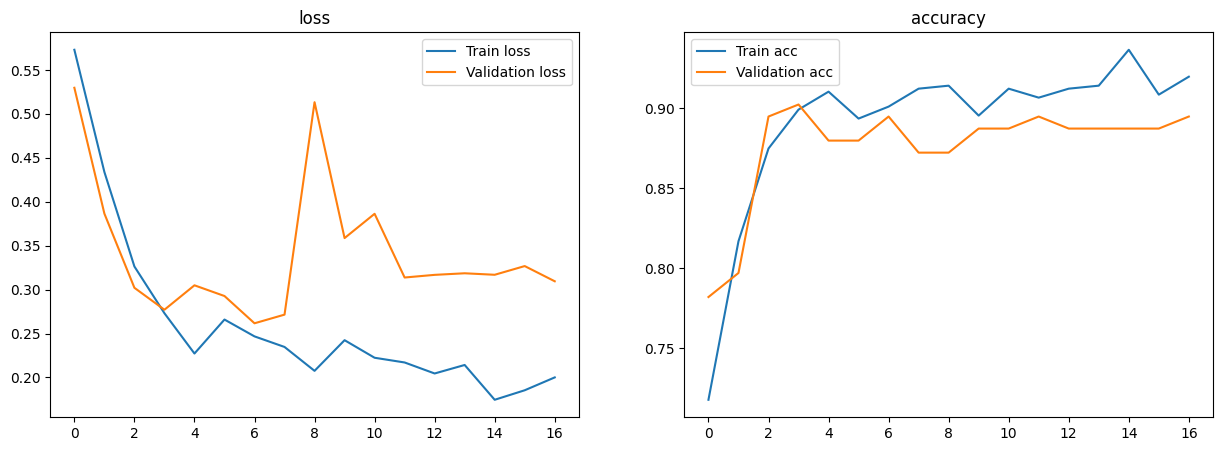

In [123]:
plot_history(history_eff_improved)

In [124]:

# Evaluate the model on test_dataset
loss, accuracy = model_eff.evaluate(test_dataset_rgb)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9067 - loss: 0.2168
Test Loss: 0.21540144085884094
Test Accuracy: 0.9100000262260437


In [125]:
import numpy as np

np.set_printoptions(suppress=True)

predic=model_eff.predict(test_dataset_rgb)
predic


4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step 


array([[0.98534334, 0.0146567 ],
       [0.02994416, 0.9700558 ],
       [0.9781386 , 0.02186141],
       [0.6958828 , 0.30411723],
       [0.04884934, 0.9511507 ],
       [0.18923378, 0.8107662 ],
       [0.8638306 , 0.13616942],
       [0.18103598, 0.818964  ],
       [0.551683  , 0.44831702],
       [0.9537119 , 0.04628801],
       [0.08567028, 0.91432977],
       [0.0058894 , 0.9941105 ],
       [0.4477472 , 0.5522528 ],
       [0.95936316, 0.04063688],
       [0.9872207 , 0.01277933],
       [0.7317148 , 0.26828519],
       [0.8597435 , 0.14025657],
       [0.92003965, 0.07996032],
       [0.14118268, 0.85881734],
       [0.5900451 , 0.4099549 ],
       [0.01077602, 0.9892239 ],
       [0.95439976, 0.04560022],
       [0.2879467 , 0.71205336],
       [0.0600221 , 0.9399779 ],
       [0.02301941, 0.97698057],
       [0.9991461 , 0.00085387],
       [0.033555  , 0.96644497],
       [0.21010381, 0.7898962 ],
       [0.98921025, 0.01078975],
       [0.6832458 , 0.31675422],
       [0.

In [118]:
def test(result):
    benign_prob = round(result[0], 2)
    malignant_prob = round(result[1], 2)

    if benign_prob >= 0.7:
        return f'The predicted probability of the lesion being benign is {benign_prob}'
    elif malignant_prob >= 0.7:
        return f'The predicted probability of the lesion malignant benign is {malignant_prob}'
    else:
        return f'Uncertainty warning! The predicted probability of the lesion being benign is only: {benign_prob}, and being malignant: {malignant_prob}'


## Shapley in practice with the SHAP package

In [143]:
# Iterate over the dataset to get X and y tensors
X_batches = []
y_batches = []

for X_batch, y_batch in dataset_rgb:
    X_batches.append(X_batch)
    y_batches.append(y_batch)

# Concatenate batches to get complete X and y tensors
X = tf.concat(X_batches, axis=0).numpy()
y = tf.concat(y_batches, axis=0).numpy()

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (535, 224, 224, 3)
y shape: (535,)


In [144]:

class_names=['benign', 'malignant']
# We will use this as input for the SHAP explainer
def model(X):
    X_copy = X.copy()

    return model_eff(X_copy)

# A masker that will mask out partitions of the input image
masker = shap.maskers.Image("blur(128,128)", X[0].shape)

# Finally create the explainer
explainer = shap.Explainer(model, masker, output_names=class_names)

# Explain some images using 500 evaluations of the model
# to estimate the SHAP values
shap_values = explainer(X[4:5], max_evals=5000, batch_size=50,
                        outputs=shap.Explanation.argsort.flip[:1],
                        silent=True)


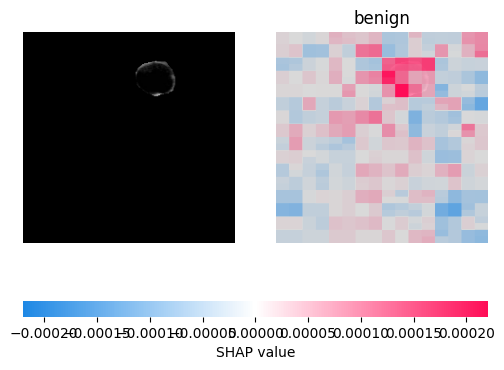

In [145]:
shap.image_plot(shap_values, pixel_values=X[4:5].astype(int))

Changes in the images 

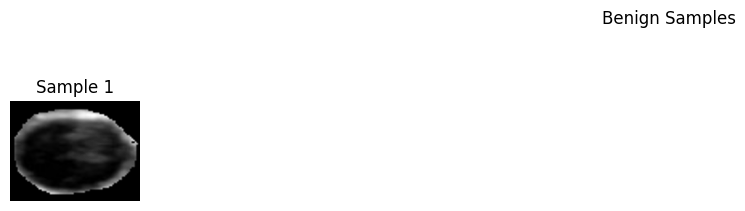

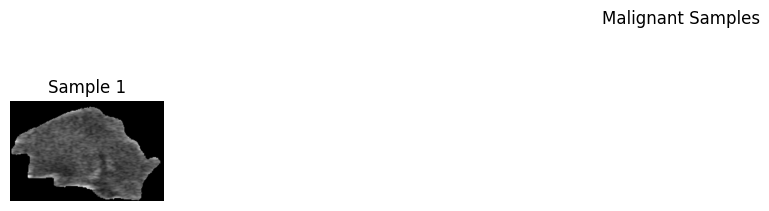

In [146]:
images_path = '/kaggle/input/images-last/images'
plot_class_samples(images_path, 'benign', num_samples=25)

plot_class_samples(images_path, 'malignant', num_samples=25)

In [147]:
# parameters for the dataset generation
batch_size = 32
img_height = 224  # what should the input size be? #224
img_width = 224   # ?

# Create training dataset from directory
images_rgb = tf.keras.preprocessing.image_dataset_from_directory(
    images_path,
    labels='inferred',
    label_mode='int',   # Labels are returned as integers
    class_names=['benign', 'malignant'], # class names
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(img_height, img_width),  # resize images to the specified size
    shuffle=True,        # shuffles the data
    seed=123,            # seed for shuffling and transformations
      # image proportion for validation

)

Found 2 files belonging to 2 classes.


In [148]:
# Iterate over the dataset to get X and y tensors
X_batches_final = []
y_batches_final = []

for X_batch_final, y_batch_final in  images_rgb:
    X_batches_final.append(X_batch_final)
    y_batches_final.append(y_batch_final)

# Concatenate batches to get complete X and y tensors
Xx = tf.concat(X_batches_final, axis=0).numpy()
yy = tf.concat(y_batches_final, axis=0).numpy()

print("X shape:", Xx.shape)
print("y shape:", yy.shape)

X shape: (2, 224, 224, 3)
y shape: (2,)


In [153]:

class_names=['benign', 'malignant']
# We will use this as input for the SHAP explainer
def model(Xx):
    Xx_copy = Xx.copy()

    return model_eff(Xx_copy)

# A masker that will mask out partitions of the input image
masker = shap.maskers.Image("blur(128,128)", Xx[0].shape)

# Finally create the explainer
explainer = shap.Explainer(model, masker, output_names=class_names)

# Explain some images using 500 evaluations of the model
# to estimate the SHAP values
shap_values = explainer(Xx[0:1], max_evals=5000, batch_size=50,
                        outputs=shap.Explanation.argsort.flip[:1],
                        silent=True)

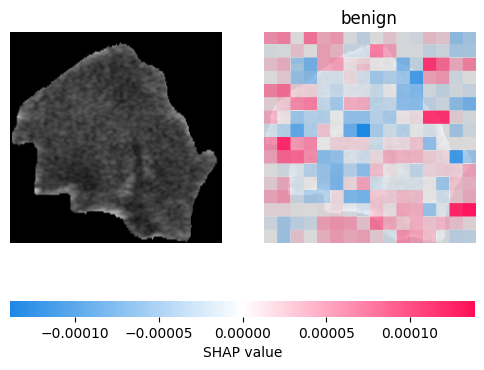

In [154]:
shap.image_plot(shap_values, pixel_values=Xx[0:1].astype(int))

## Performance metrics

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


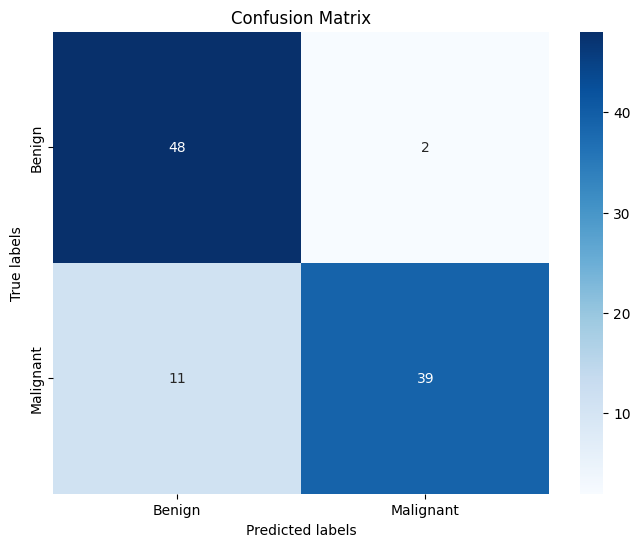

In [155]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np


# Initialize lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Get true and predicted labels for all samples in the test dataset
for images, labels in test_dataset_rgb:
    batch_predictions = model_eff.predict(images)
    batch_predicted_labels = np.argmax(batch_predictions, axis=1)
    batch_true_labels = labels.numpy()
    true_labels.extend(batch_true_labels)
    predicted_labels.extend(batch_predicted_labels)

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [158]:
from sklearn.metrics import recall_score

recall_score(true_labels,predicted_labels, average=None)

array([0.96, 0.78])

In [159]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score



print('Accuracy =', round(accuracy_score(true_labels, predicted_labels), 2)) # Accuracy

print('Precision =', round(precision_score(true_labels, predicted_labels), 2)) # Precision

print('Recall =', round(recall_score(true_labels, predicted_labels), 2)) # Recall

print('F1 score =', round(f1_score(true_labels, predicted_labels), 2)) # F1 score

Accuracy = 0.87
Precision = 0.95
Recall = 0.78
F1 score = 0.86


In [160]:
from sklearn.metrics import precision_recall_curve


precision, recall, thresholds = precision_recall_curve(true_labels, predic[:,1])

precision, recall, thresholds

(array([0.5       , 0.49494949, 0.5       , 0.49484536, 0.48958333,
        0.49473684, 0.5       , 0.49462366, 0.5       , 0.49450549,
        0.5       , 0.49438202, 0.48863636, 0.48275862, 0.47674419,
        0.48235294, 0.48809524, 0.48192771, 0.47560976, 0.48148148,
        0.475     , 0.48101266, 0.48717949, 0.48051948, 0.47368421,
        0.48      , 0.47297297, 0.47945205, 0.47222222, 0.47887324,
        0.48571429, 0.49275362, 0.5       , 0.50746269, 0.5       ,
        0.49230769, 0.484375  , 0.47619048, 0.46774194, 0.45901639,
        0.45      , 0.45762712, 0.46551724, 0.47368421, 0.48214286,
        0.49090909, 0.48148148, 0.49056604, 0.5       , 0.50980392,
        0.52      , 0.51020408, 0.52083333, 0.53191489, 0.52173913,
        0.51111111, 0.5       , 0.48837209, 0.5       , 0.48780488,
        0.475     , 0.48717949, 0.47368421, 0.45945946, 0.44444444,
        0.42857143, 0.44117647, 0.45454545, 0.46875   , 0.48387097,
        0.5       , 0.51724138, 0.5       , 0.51

In [161]:
scores = pd.DataFrame({'threshold':thresholds,
                       'precision': precision[:-1],
                       'recall':recall[:-1]}) # Store in a dataframe
scores

,threshold,precision,recall
0,0.000491,0.500000,1.00
1,0.000854,0.494949,0.98
2,0.001833,0.500000,0.98
3,0.002038,0.494845,0.96
4,0.003671,0.489583,0.94
...,...,...,...
95,0.990630,0.400000,0.04
96,0.992910,0.500000,0.04
97,0.993243,0.666667,0.04
98,0.994087,1.000000,0.04


Text(0.5, 0, 'recall')

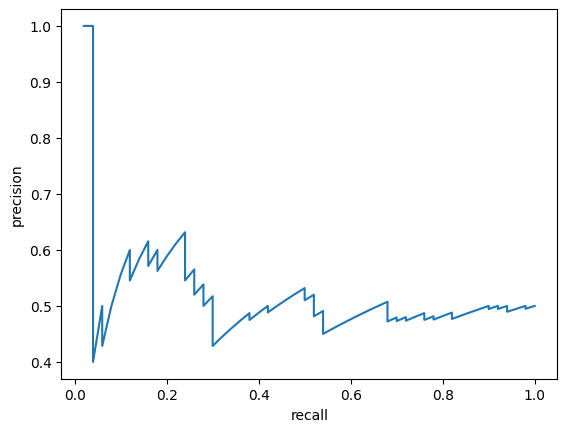

In [162]:
plt.plot(scores['recall'],scores['precision'])
plt.ylabel('precision')
plt.xlabel('recall')

In [163]:
scores[scores['recall'] >= 0.9].threshold.max()

0.009393498